In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
save_model = False
do_training = True
plot_train_curve = False
save_synthetic_samples = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
# synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space//DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
airplane


In [7]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'mlp_pc_gen_default_leak_20'

leak = 0.2
adaptive_training = None
beta = 0.5

discriminator = mlp_discriminator
generator = point_cloud_generator

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
gen_kwargs = {'b_norm': False}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [8]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

405 pclouds were loaded. They belong in 1 shape-classes.
3438 pclouds were loaded. They belong in 1 shape-classes.
202 pclouds were loaded. They belong in 1 shape-classes.


In [9]:
training_data = in_data['train']
n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [ ]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.363884918829974, 0.70986539388404168) 15.851927042


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


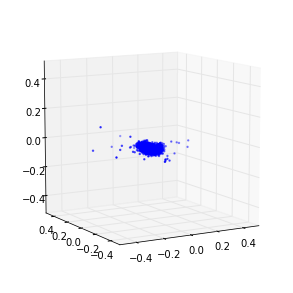

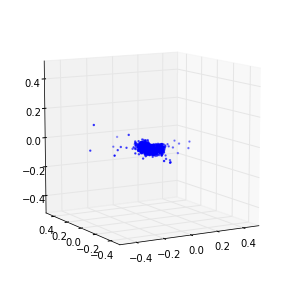

2 (1.3704320297521704, 0.72064447227646322) 15.4240808487
3 (1.3605772046481861, 0.73680935361806088) 15.4990830421
4 (1.3554961120381075, 0.75901694157544308) 15.5151200294
5 (1.3507088089690489, 0.7324201762676239) 15.5147411823


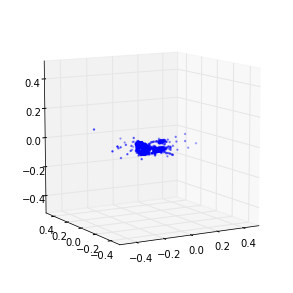

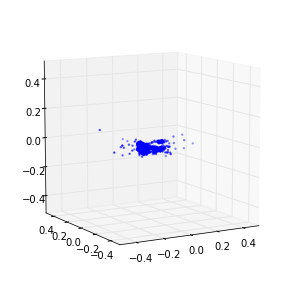

6 (1.2606756880002863, 0.79818413976360769) 15.5485329628
7 (1.1891763937823914, 0.9107430235427969) 15.5786309242
8 (1.1531933195450728, 1.0059790514847811) 15.6469559669
9 (1.1217440410571939, 1.0795028840794283) 15.685477972
10 (1.060841260587468, 1.0913834361469044) 15.8450698853


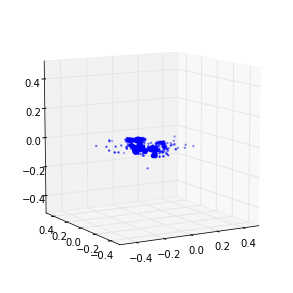

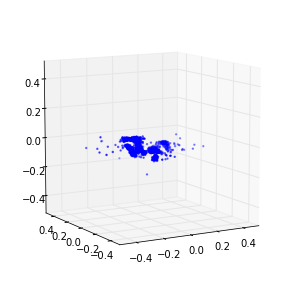

11 (1.1624073219649933, 1.0870565798352747) 15.7472741604
12 (1.3213749177315657, 0.89343683596919565) 16.1339559555
13 (1.2933702503933626, 0.78890768570058489) 16.1841139793
14 (1.296533300596125, 0.82464178432436552) 15.9270701408
15 (1.3144697652143591, 0.82255150903673735) 15.9727141857
16 (1.2280116414322573, 0.84404403497191038) 16.2877850533
17 (1.3236095607280731, 0.82778312441180735) 15.8258891106
18 (1.2669631242752075, 0.83792925143943109) 15.8319921494
19 (1.3213177831733929, 0.79307517584632425) 16.1323599815
20 (1.3156967408516829, 0.797326435937601) 15.9185409546
21 (1.3217034620397232, 0.80174807941212378) 15.8752140999
22 (1.3293671572909636, 0.79085664714083947) 15.7983858585
23 (1.3242889502469231, 0.82819270474069262) 15.7857289314
24 (1.34310842962826, 0.79940978656796846) 15.7225139141
25 (1.301642053267535, 0.79277625767623672) 16.3242070675
26 (1.3347137675565832, 0.79526749691542453) 15.8109807968
27 (1.3369112453039955, 0.77592345721581402) 15.7345430851
28 (

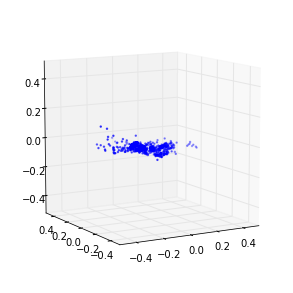

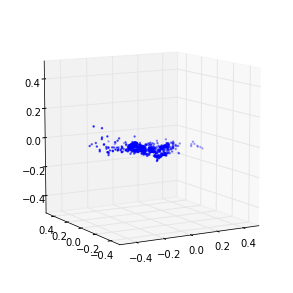

51 (1.3376920240766861, 0.75148042335229759) 15.8179700375
52 (1.348419545327916, 0.77820228566141691) 15.8526570797
53 (1.3376968152382795, 0.77171122414224291) 15.9271559715
54 (1.3490234297864578, 0.7724680102923337) 15.8452439308
55 (1.3409332878449385, 0.79334613067262316) 15.6330199242
56 (1.3288599796154921, 0.77888202930197992) 15.7804229259
57 (1.3167042539400213, 0.7872070827904869) 15.9711329937
58 (1.3306655042311724, 0.783470060895471) 15.7518489361
59 (1.3376187980175018, 0.7729298209442812) 15.9529480934
60 (1.3371279134469873, 0.76652701724978056) 15.7740960121
61 (1.3447487932794235, 0.75707228481769562) 15.9415669441
62 (1.3437580746762894, 0.75065560901866235) 15.716449976
63 (1.3268298015874975, 0.75824486946358405) 15.6559112072
64 (1.3502756760400885, 0.76734255078960867) 15.7537350655
65 (1.3483766089467442, 0.77534120486063118) 15.7064740658
66 (1.339491507586311, 0.76594285316327038) 16.1981840134
67 (1.3340144946294672, 0.77158425485386573) 15.8230400085
68 (1

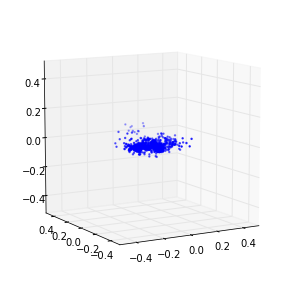

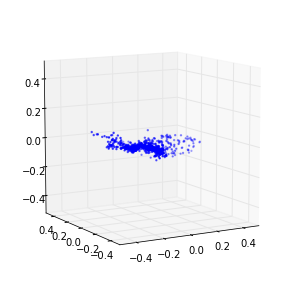

101 (1.3627653577748466, 0.7445046209237155) 15.7806890011
102 (1.3636613979059107, 0.75265290807275209) 15.7569518089
103 (1.3629451131119448, 0.73667970387374648) 16.1927518845
104 (1.3622613338863148, 0.73422666156993188) 15.6553552151
105 (1.3648013384903179, 0.74062693206702956) 16.0423259735
106 (1.3631063314045178, 0.73698863913031187) 15.7565019131
107 (1.3585243260159212, 0.74287333295625801) 15.8988249302
108 (1.3594517742886263, 0.74139845897169676) 15.7346599102
109 (1.3570510219125187, 0.74353484634090872) 16.0613920689
110 (1.3575438383747549, 0.75090061303447275) 15.7615289688
111 (1.3661347522455103, 0.74884896155665903) 15.7879860401
112 (1.3573156612760879, 0.74808912154506235) 16.1828761101
113 (1.3616418347639196, 0.74688305924920473) 15.8016171455
114 (1.3564054597826565, 0.73448102526804981) 15.8663189411
115 (1.362027496099472, 0.74397934096701002) 16.0837540627
116 (1.357549819876166, 0.74411846960292138) 15.7370772362
117 (1.3659774047486923, 0.7483646107070586

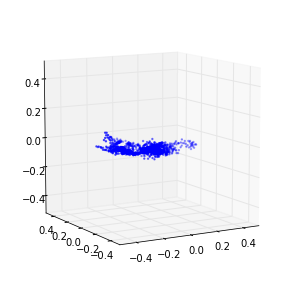

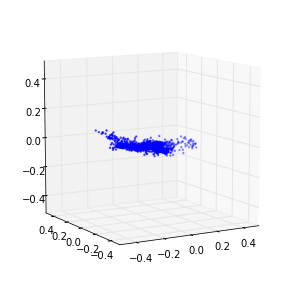

151 (1.3736627978437088, 0.73871635864762697) 15.6821501255
152 (1.3686277901425081, 0.74208985181415787) 15.7156889439
153 (1.3640832673100864, 0.74469893557183886) 15.9845221043
154 (1.3627929424538332, 0.73806675830308133) 15.693253994
155 (1.3651901904274435, 0.73830167949199677) 15.9474880695
156 (1.3692228951874901, 0.73948909166981192) 15.6924209595
157 (1.365517242866404, 0.74434710337835197) 15.7858409882
158 (1.3676770750214071, 0.74489652496926928) 15.7531869411
159 (1.3636828310349409, 0.73322336375713348) 15.7571258545
160 (1.3692044405376209, 0.73692662225050087) 16.2735190392
161 (1.3601453093921436, 0.75195180230280934) 15.6889679432
162 (1.3662954323432024, 0.73589119402801284) 15.8838088512
163 (1.3630574415711796, 0.74317528921015119) 15.7317709923
164 (1.3617565123473896, 0.74097207013298483) 15.7639300823
165 (1.3634476030574125, 0.74084109769147988) 16.0107038021
166 (1.3584117889404297, 0.74617623143336353) 15.8345730305
167 (1.361438092063455, 0.7394688392386716

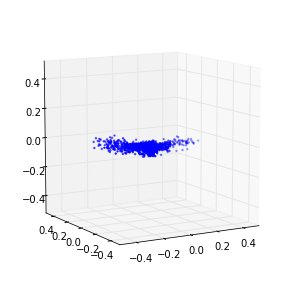

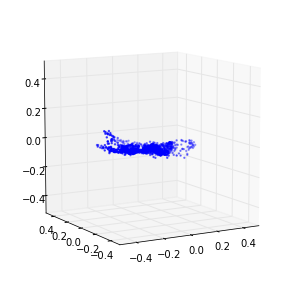

201 (1.3432956530767328, 0.76908276975154877) 15.7240958214
202 (1.344705599195817, 0.7649652510881424) 15.848803997
203 (1.3308828385437237, 0.76627657343359556) 15.9529261589
204 (1.3251701786237604, 0.77120625096208906) 15.8620738983
205 (1.3397648457218618, 0.7710921102586914) 15.8505089283
206 (1.3251967763199526, 0.77071696081582242) 15.824641943
207 (1.339582448496538, 0.77793496365056314) 15.7279210091
208 (1.3373848252436693, 0.7768710316980586) 16.0455288887
209 (1.3329362816670363, 0.77196461312911091) 15.7737729549
210 (1.3255208345020519, 0.77433925691772909) 15.8041219711
211 (1.3353714662439682, 0.78161912279970502) 15.8394958973
212 (1.3335286168491138, 0.78259195737978993) 15.9302999973
213 (1.3316131970461678, 0.77592889613964977) 15.8241791725
214 (1.3289342785582823, 0.78267076348557196) 15.6701929569
215 (1.3301250180777382, 0.77451702163499947) 15.9435939789
216 (1.3138066547758438, 0.78343353814938488) 15.671225071
217 (1.3184439417193918, 0.78190273747724648) 15

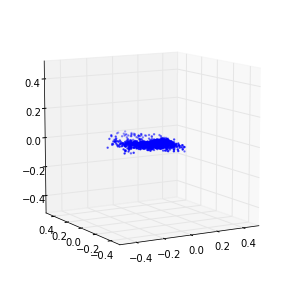

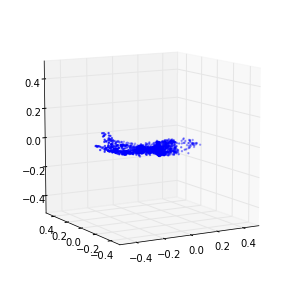

251 (1.2737977942999672, 0.83545262848629676) 15.6675038338
252 (1.2684027587666231, 0.83137596354765053) 15.9810171127
253 (1.2709474598660189, 0.84502460588427153) 15.7153289318
254 (1.2893540385891409, 0.84076997374787055) 16.0096158981
255 (1.2809149500201731, 0.84171704816467618) 15.7258181572
256 (1.2771740450578577, 0.83319468270329866) 15.7347979546
257 (1.2821353060357712, 0.84375012841294794) 15.91487813
258 (1.2795343679540299, 0.83800137305960931) 16.0930240154
259 (1.2731702327728271, 0.85041227849090806) 15.7281010151
260 (1.2840184955035938, 0.83973778959582834) 16.0619950294
261 (1.2546191934277029, 0.84483617281212531) 15.6797640324
262 (1.2604912046123953, 0.85038763459991007) 15.7067041397
263 (1.2689352438730352, 0.85847324790323487) 15.7538290024
264 (1.2705607677207273, 0.84455492654267483) 15.7959861755
265 (1.2647870147929472, 0.84170520656249104) 15.9098639488
266 (1.2596099289024578, 0.86523998484892006) 15.6861560345
267 (1.2618844929863424, 0.859553178005358

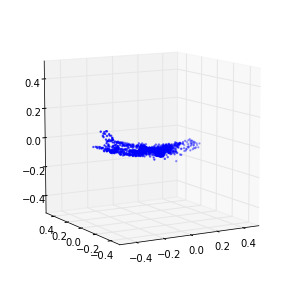

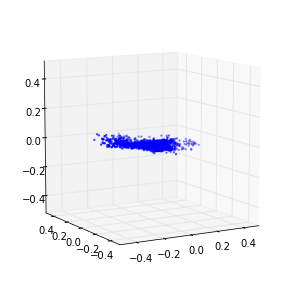

301 (1.2236988036071552, 0.92118153370478573) 15.8000228405
302 (1.2300799874698414, 0.90983913838863373) 15.8263809681
303 (1.2303908046554117, 0.90199285920928507) 15.8503549099
304 (1.207538515329361, 0.91122836751096392) 15.811218977
305 (1.2259731485563166, 0.9165382512352046) 15.6914741993
306 (1.2249914705753326, 0.9271148013717988) 16.0373511314
307 (1.217592228861416, 0.91903406644568719) 15.8086118698
308 (1.1776461215580212, 0.9413050492020214) 15.8557920456
309 (1.2094145557459663, 0.94115019282873935) 15.9232740402
310 (1.1843287576647366, 0.93248365468838634) 15.7358319759
311 (1.2006918542525347, 0.9356354562675252) 15.6888179779
312 (1.2018930315971375, 0.95139854313696137) 15.957005024
313 (1.2074896184837116, 0.94672592729330063) 15.8235838413
314 (1.1895286581095528, 0.97300819263738747) 15.7488360405
315 (1.2118752335800844, 0.98889561786371116) 15.9385411739
316 (1.1867501910995035, 0.9475132025340024) 15.8758411407
317 (1.1693080278003918, 0.97597434897633162) 15.

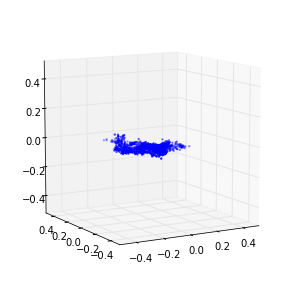

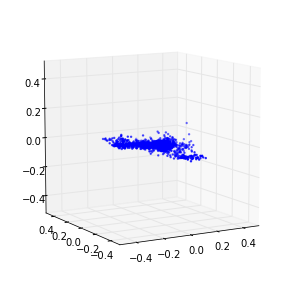

351 (1.1356777978294037, 1.0687684486894047) 15.686057806
352 (1.1231046608265709, 1.0507573454695589) 15.8850598335
353 (1.1219034387784845, 1.0593313285533119) 16.1397337914
354 (1.1433476788156174, 1.0526720627265818) 15.7418749332
355 (1.1205275584669674, 1.0208610489087946) 15.7772779465
356 (1.1585129972766428, 1.0638496476937742) 15.8048980236
357 (1.1393249657224207, 1.0459305359160198) 15.7445650101
358 (1.1144947050248875, 1.0548055421780138) 15.6783161163
359 (1.1279533934943817, 1.0519740357995033) 15.6673901081
360 (1.1331592044409584, 1.0677617271156872) 15.7136039734
361 (1.1467910706996918, 1.0749754292123459) 15.8115758896
362 (1.1455721162697847, 1.0460002334678875) 15.8745810986
363 (1.1269960096653771, 1.0541387257330559) 15.6973481178
364 (1.1337452057529898, 1.0628312681527698) 15.9338200092
365 (1.142275795340538, 1.0809124936075771) 18.6722769737
366 (1.1351253381546806, 1.0625182451570736) 19.9039821625
367 (1.1471044622799929, 1.0715432780630447) 15.6790239811

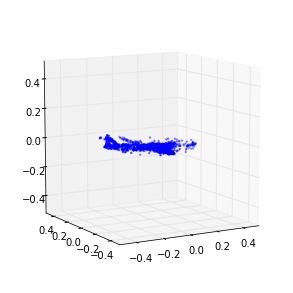

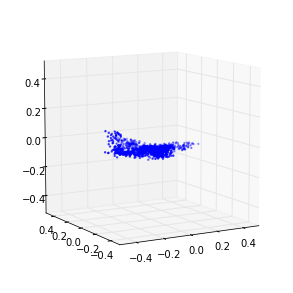

401 (1.0819907021873139, 1.1085603780606215) 15.8145320415
402 (1.0850668882622438, 1.1218353168052786) 15.6517691612
403 (1.0569060225697124, 1.1217541694641113) 15.7177181244
404 (1.0819297608207255, 1.1132738318513422) 15.6875908375
405 (1.0898054803118986, 1.1478020395426189) 15.7359390259
406 (1.0726309295962839, 1.1475394705639166) 16.0004031658
407 (1.1198834873297636, 1.1663643323323305) 15.7653310299
408 (1.073918953537941, 1.1382274101762211) 15.8437058926
409 (1.047114587005447, 1.1679301971898359) 15.642911911
410 (1.050275429206736, 1.1450821389170254) 15.8181011677
411 (1.1019319339710123, 1.182817354798317) 15.7154381275
412 (1.0575905827914966, 1.1797415136414415) 15.8484790325
413 (1.1154077543931848, 1.1723554520046009) 15.7918641567
414 (1.0742730305475348, 1.1413028424277025) 15.7869999409
415 (1.0680619434398764, 1.16385265264441) 15.9570770264
416 (1.0537589087205774, 1.133348309818436) 15.8294529915
417 (1.0741730902124853, 1.1840670538299225) 15.7543540001
418 (

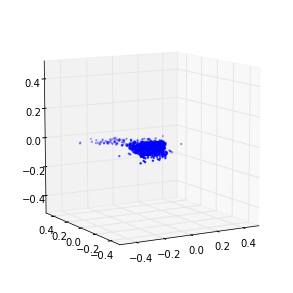

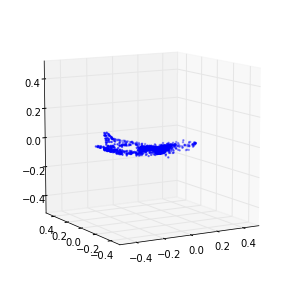

451 (1.0372496939757292, 1.231171825352837) 24.1952998638
452 (1.0382056613178814, 1.237895956810783) 26.8322868347
453 (1.0288191402659697, 1.2458415969329721) 18.7967698574
454 (1.0554085373878479, 1.2721146722050274) 15.9731450081
455 (1.0376248683999567, 1.2243220788591049) 15.924503088
456 (1.0345550205777674, 1.1988727077841759) 15.7850461006
457 (1.0495159152676077, 1.1755640559336717) 15.7476160526
458 (1.0731637898613424, 1.2163889110088348) 15.9454190731
459 (1.0788411015973371, 1.2204204017625135) 15.9726281166
460 (1.0470571693252115, 1.1941719581099117) 15.6923549175
461 (1.0245232310365229, 1.2235268345650505) 15.6388161182
462 (1.0247878204373753, 1.2469690012581207) 15.7374510765
463 (1.0082536103094326, 1.2370852941975874) 15.7396030426
464 (0.99913575193461246, 1.2288849485271118) 15.9635078907
465 (1.0205535643240984, 1.2613275121240055) 15.7236790657
466 (1.0609200754586388, 1.2638275421717589) 15.6881351471
467 (1.0217653451596989, 1.2823988497257233) 15.8054528236

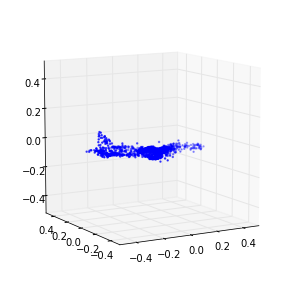

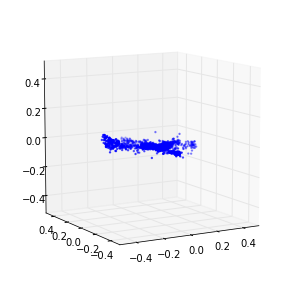

501 (0.99855125914601717, 1.2882728261106156) 15.8334798813
502 (0.98632430767311774, 1.2859078768421621) 15.7349281311
503 (0.99747653393184432, 1.3142770020400776) 15.8147079945
504 (1.0181801783687927, 1.2806186123805887) 15.8799419403
505 (0.98618752903798046, 1.2708371421870064) 15.8861689568
506 (1.0038673518335117, 1.2846984810688917) 15.7425150871
507 (1.0470021857934839, 1.3104991720003241) 15.648455143
508 (1.057463477639591, 1.2846311584991568) 15.7031760216
509 (1.0274745778125876, 1.2413227715912987) 15.8115069866
510 (1.0086127265411264, 1.242229749174679) 15.7772660255
511 (1.0319554236005335, 1.2740153052351053) 16.2922978401
512 (1.0357642243890202, 1.3070890850880568) 15.9185390472
513 (1.0407631546258926, 1.3047267847201403) 15.8207149506
514 (0.99954890678910646, 1.2946131062858246) 15.7128579617
515 (0.96989250533721028, 1.3060146517613356) 15.9276580811
516 (1.0253558378009235, 1.3180875199682571) 15.8979420662
517 (1.0694605480222141, 1.3008463509819086) 15.86024

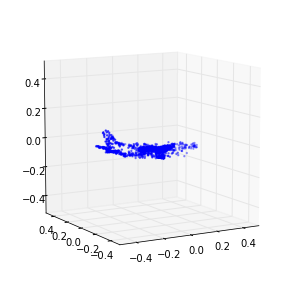

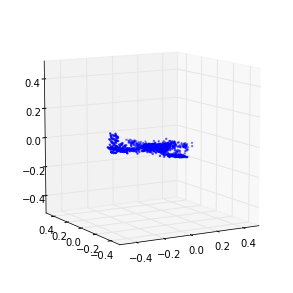

551 (1.0251620464465196, 1.2650519819820629) 15.826802969
552 (0.97243742820094614, 1.2819463952499277) 15.6514999866
553 (0.9879652586053399, 1.3141741621143677) 15.8983080387
554 (0.98795632404439593, 1.3140891273232067) 15.771201849
555 (0.97961857301347399, 1.2719202734091704) 15.8121240139
556 (0.96972584461464606, 1.317607367739958) 15.6715419292
557 (1.0627353515695124, 1.3944304353174042) 16.0102748871
558 (1.0214847317513298, 1.3561607936725897) 15.6407909393
559 (1.037244407569661, 1.3328059749568211) 15.9963068962
560 (0.9792018313618267, 1.305313300122233) 15.9992930889
561 (1.0053412844153011, 1.288804574047818) 15.866533041
562 (1.0111348287147635, 1.2490808735875523) 15.806055069
563 (0.98046303584295158, 1.2629778639358633) 15.8963489532
564 (1.0386407252620249, 1.3122385578120457) 16.0729489326
565 (0.97433339234660654, 1.2966833000673967) 15.6372768879
566 (1.007418831481653, 1.2775389911497341) 15.6760308743
567 (1.0400721833986395, 1.3065786313484697) 15.8152489662


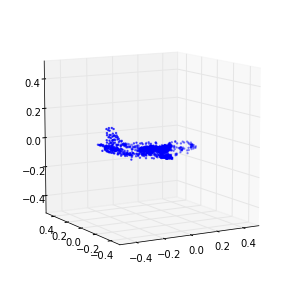

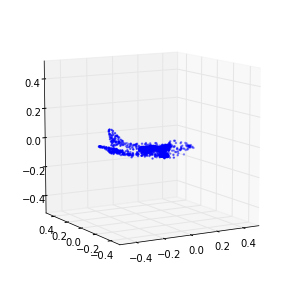

601 (0.98497298447524795, 1.3449554013855316) 15.7126700878
602 (0.97667553845573873, 1.312080427127726) 15.6307132244
603 (0.98861391228788043, 1.3187444315237158) 15.6172420979
604 (0.9860855367253808, 1.3374870603575426) 15.9373419285
605 (0.95783939256387596, 1.3117876289521946) 15.9459550381
606 (0.9645778221242568, 1.3249791264533997) 15.6422979832
607 (1.0099789631717346, 1.3570003969704403) 16.0361549854
608 (1.0065522491931915, 1.3354146191302467) 15.9686949253
609 (0.98831073676838599, 1.3327933633152176) 15.9530580044
610 (0.95476372014073763, 1.3798996551948435) 15.8082590103
611 (0.95986758260165939, 1.3563715947024964) 15.6873660088
612 (0.97712413353078509, 1.3327925731154049) 16.1663150787
613 (0.96221667002229128, 1.3503346776261049) 15.8296210766
614 (0.99155347575159636, 1.311713803340407) 16.0969161987
615 (1.0001321697936338, 1.2889152370831545) 15.9204018116
616 (0.99777876015971689, 1.3152657326530008) 15.981844902
617 (1.0140518397092819, 1.3109434312757324) 15.

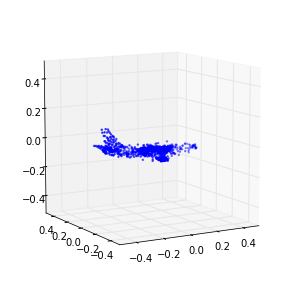

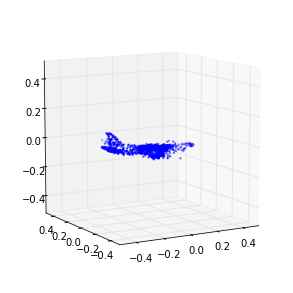

651 (1.0267128620077581, 1.3439120711649166) 16.0086758137
652 (1.0146730095148087, 1.3084228371872622) 18.8915040493
653 (0.97110552998150101, 1.3314761721036013) 15.7202820778
654 (0.97919466565637026, 1.3334023312610739) 16.1193099022
655 (1.0050039466689615, 1.3077555421520681) 15.9920680523
656 (1.0055514039362179, 1.3632337398388807) 15.7328691483
657 (1.0192011603537727, 1.3380671406493467) 16.101462841
658 (1.0120675257023644, 1.3000534457318924) 15.6905550957
659 (1.0133113194914425, 1.3346853589310366) 20.8543031216
660 (0.98083336213055783, 1.2922026541303187) 15.9152338505
661 (1.0089505972231136, 1.2938798192669363) 15.9442200661
662 (0.9933701227692997, 1.3143895364859526) 16.0570371151
663 (1.0231273700209225, 1.2674663128221737) 15.6885411739
664 (1.0252822427188648, 1.26356312413426) 15.8888771534
665 (1.0162643422098721, 1.2770830138641245) 16.0799348354
666 (1.0239119056393118, 1.3051424473524094) 15.6790928841
667 (1.0203802033382303, 1.2859967745402281) 15.92159414

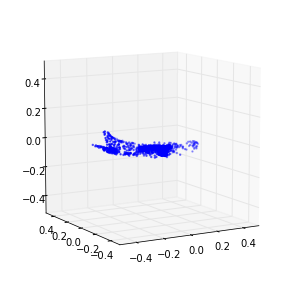

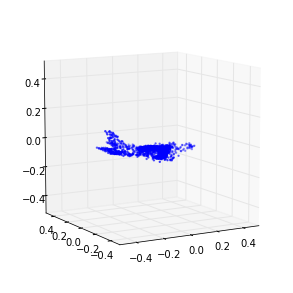

701 (1.0432658546111162, 1.3089146307286095) 25.9155170918
702 (0.99595697750063505, 1.2785520676304312) 15.6924190521
703 (0.96628899346379671, 1.3880874019335299) 16.1216671467
704 (0.9673168299829259, 1.3494938752230476) 16.0208928585
705 (0.94904467288185568, 1.3669783210053164) 15.7014949322
706 (0.97544969881282129, 1.3635041726862682) 16.2701668739
707 (1.0120689211522831, 1.3201806738096125) 15.9596641064
708 (0.99777529081877536, 1.3257484593812157) 16.0599081516
709 (1.0155078085029827, 1.3103284651742262) 16.9400029182
710 (0.99396380168550158, 1.3188756011864717) 15.7286388874
711 (1.0261290362652611, 1.3370754464584238) 15.8842720985
712 (1.0344999309848337, 1.3278230840668959) 16.2075870037
713 (0.99244025963194227, 1.3077933985520811) 15.8443231583
714 (0.97976692722124215, 1.3238522927550709) 16.1173942089
715 (0.99850014378042784, 1.3442086209269131) 15.956843853
716 (1.0030137510860668, 1.3307161112042034) 15.7412090302
717 (0.99324378195930929, 1.3570287078619003) 15

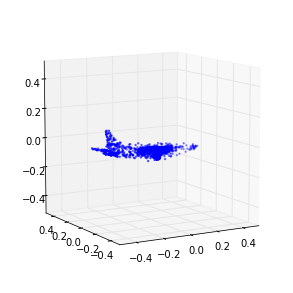

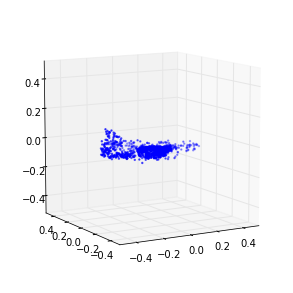

751 (0.98584721456555757, 1.2810394439627142) 15.704515934
752 (1.0083627604386385, 1.3034518501337837) 15.68810606
753 (1.0372369403348249, 1.2872559301116888) 16.1492810249
754 (1.0540691307362389, 1.2873804424615467) 19.0370180607
755 (0.98991867286317492, 1.3006931394338608) 15.7138688564
756 (1.0162696680601906, 1.3020662893267239) 16.1143419743
757 (0.96073493712088642, 1.3479822646169102) 15.7108738422
758 (0.98617745848263016, 1.3295117537764942) 15.9594619274
759 (0.98634932234006767, 1.3037128124166937) 15.820964098
760 (0.98944940637139711, 1.3128498547217424) 15.7608139515
761 (1.0065867751836777, 1.3292783007902258) 15.8625729084
762 (0.99045826231732093, 1.2891916439813726) 15.9124491215
763 (1.01425099197556, 1.338213658946402) 15.6989889145
764 (1.0043915755608503, 1.3192632671664744) 15.9665119648
765 (1.007193675812553, 1.3068736151737326) 15.7535841465
766 (0.99528336086693936, 1.3028335466104395) 15.8182251453
767 (1.0074097137240803, 1.300980682758724) 15.682901859

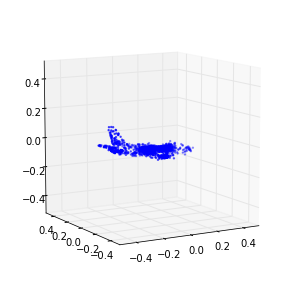

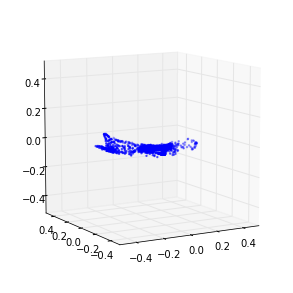

801 (0.96968005948206959, 1.3790831855114769) 15.7065188885
802 (0.9817040212014142, 1.3398437824319391) 16.883384943
803 (0.97526513741296883, 1.3701752871274948) 15.6731030941
804 (0.95540476546568032, 1.3494630026466705) 16.1195240021
805 (0.98992055040948534, 1.3746774967978983) 16.4109330177
806 (0.9771114990991705, 1.3780013901345871) 16.1694898605
807 (0.95077931880950928, 1.3611291234984118) 15.9539489746
808 (0.97724847320248098, 1.3762250437456018) 15.7351469994
809 (0.94814099020817699, 1.3667494277743732) 16.1984889507
810 (0.96658741375979251, 1.3556865769274093) 16.0591700077
811 (0.97087151688687945, 1.3659242926275028) 16.3488490582
812 (0.96328596244840059, 1.3784649056546829) 16.8154509068
813 (0.9797694981098175, 1.3839882016181946) 15.8084030151
814 (0.99965754940229301, 1.3364918341531473) 15.7951300144
815 (0.97687566806288328, 1.3457956121248358) 16.3747987747
816 (0.99914769740665665, 1.3239155933260918) 16.603427887
817 (1.0008424424073274, 1.3324209960067974) 

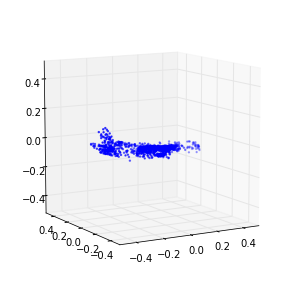

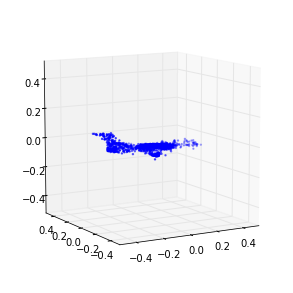

851 (0.9713597429149291, 1.328160278060857) 16.3249628544
852 (0.99122243856682501, 1.3632645405390684) 15.9710180759
853 (0.97677529822377596, 1.3356176772538353) 16.2331609726
854 (0.97858393718214598, 1.3413377632113064) 15.9528031349
855 (1.0005569983931148, 1.3544197152642643) 16.1820130348
856 (0.96593231751638298, 1.3542037579943151) 15.9367890358
857 (1.0328537804238938, 1.3670881522052429) 16.1020400524
858 (1.0032374192686642, 1.3662148819250219) 16.450507164
859 (0.97532682734377241, 1.3427658685866524) 16.0237588882
860 (0.96128613633268023, 1.3674798686714733) 16.1597630978
861 (1.0132977305089725, 1.3401012604727465) 16.2863631248
862 (0.94186665030086747, 1.3142002829734016) 16.1233949661
863 (0.97273378863054161, 1.3379712586893755) 16.1598620415
864 (0.96856266873724317, 1.3609881269581177) 15.9150910378
865 (1.0158957330619587, 1.3684556791011024) 16.581225872
866 (0.99291859041242037, 1.3468541204929352) 17.0250110626
867 (1.0034948096555822, 1.351785058484358) 15.80

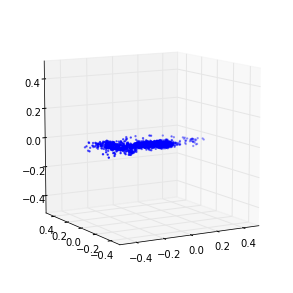

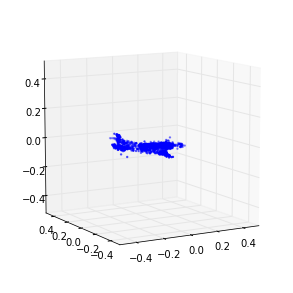

901 (0.99391181679332963, 1.2988098268123234) 16.8489089012
902 (0.97866110065404111, 1.3206576293005663) 15.7952959538
903 (1.0159321558826111, 1.3062192604822271) 15.8525280952
904 (1.0108987960745306, 1.3020559996366501) 16.4165799618
905 (0.98570343939697036, 1.3108855731347029) 16.0271909237
906 (0.98958587558830491, 1.3075745272285797) 16.8662319183
907 (1.0068531842792736, 1.3053008598439835) 15.8904469013
908 (0.98179832714445447, 1.3050166762927) 16.1521608829
909 (0.99040007854209222, 1.3234099070815479) 16.9397768974
910 (1.0139431147014393, 1.3417620781589956) 17.0070898533
911 (0.97807546047603378, 1.3123350555405897) 15.9780459404
912 (1.0222209621878231, 1.3405711756033056) 16.5700659752
913 (1.0032352436991299, 1.3174704251920475) 15.9264988899
914 (1.0215380647603203, 1.3248436705154532) 16.4586760998
915 (1.0033429466626222, 1.3065918079193901) 16.4688148499
916 (0.99529382849440851, 1.3361495978692) 15.7129201889
917 (0.98036317439640275, 1.338013554320616) 16.296521

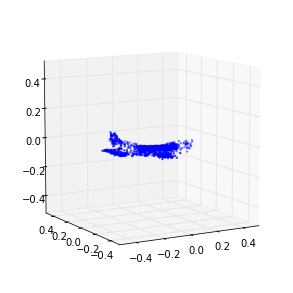

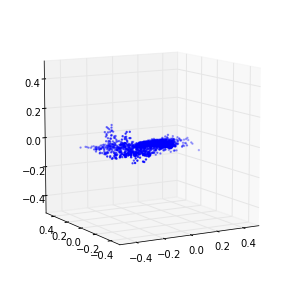

951 (0.92322486376061164, 1.3684632085701998) 15.8399250507
952 (0.953029586111798, 1.3924238112042933) 16.197726965
953 (0.98146213415791006, 1.4005882332430166) 16.6209630966
954 (0.97214092927820539, 1.3616376720807131) 16.3666269779
955 (0.99296966019798727, 1.3482072248178369) 16.2347700596
956 (0.98469656618202439, 1.3517584441339268) 15.9573760033
957 (0.95987569584566002, 1.3740633042419659) 15.9321568012
958 (0.95201291845125313, 1.3458812306909) 16.1909108162
959 (0.93389281630516052, 1.4197753957089256) 16.5370078087
960 (0.93545439927016982, 1.3843253763283001) 16.1125741005
961 (0.94509070936371298, 1.3514587059617043) 16.2438230515
962 (0.93477622112807102, 1.3986415144275217) 15.7296619415
963 (0.96913605753113241, 1.3906919719541775) 16.2841238976
964 (0.9650285787442151, 1.3897010920678867) 16.0797288418
965 (0.96261580376064071, 1.3466079384088516) 16.1890830994
966 (0.95857146031716289, 1.3488960204755558) 15.8516259193
967 (0.9657967213322135, 1.3485705081154318) 15

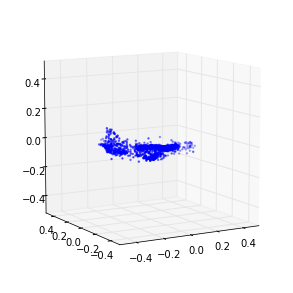

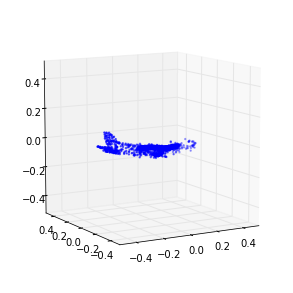

1001 (0.9486527802313075, 1.3600791692733765) 15.9220569134
1002 (0.90577809775576867, 1.3914281235021704) 16.3064491749
1003 (0.95246966358493357, 1.4103671435047598) 16.294093132
1004 (0.95455651861779833, 1.4164605789324816) 15.8477218151
1005 (0.93106666470275201, 1.384777274201898) 15.9906241894
1006 (0.93529628567835865, 1.3798059014713062) 15.7570900917
1007 (0.94683318541330452, 1.3962626974372303) 16.0401239395
1008 (0.92185700640958901, 1.3681938981308657) 15.7881009579
1009 (0.92258235549225531, 1.3885968073325998) 16.1373279095
1010 (0.96176205224850597, 1.3862137435113682) 16.0049519539
1011 (0.97346556624945468, 1.4064488551195931) 15.9553589821
1012 (0.96768906361916485, 1.3839596115490969) 15.9957020283
1013 (0.94901627740439243, 1.3589512951233809) 15.8661191463
1014 (0.94009129177121553, 1.3407433208297281) 16.29241395
1015 (0.968558215043124, 1.3618927589234184) 16.5739381313
1016 (0.94975887852556562, 1.3447786175152834) 16.611135006
1017 (0.98769683872952185, 1.350

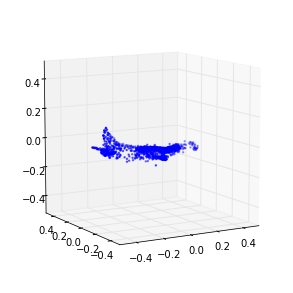

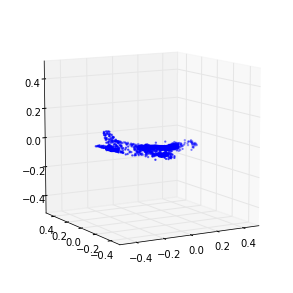

1051 (0.92180833571097431, 1.3528660982847214) 15.7250070572
1052 (0.93623482392114754, 1.3526786513188307) 15.9603450298
1053 (0.91672078476232643, 1.39490225472871) 16.5478489399
1054 (0.92852068911580476, 1.3656285089604996) 16.6192259789
1055 (0.94302152009571305, 1.3822411325047999) 16.7321391106
1056 (0.92908751876915208, 1.3664740797351389) 16.2455918789
1057 (0.94616528293665714, 1.3852969337912167) 15.7519650459
1058 (0.93814394491560316, 1.356860233580365) 16.5048959255
1059 (0.90768792085787831, 1.3669783630791832) 15.7672948837
1060 (0.92649421446463642, 1.3799249591196285) 15.9181210995
1061 (0.91110529706758614, 1.4188181135584326) 16.1489858627
1062 (0.9098901494460947, 1.4363060453358818) 16.2324419022
1063 (0.94393474827794466, 1.4018402134670931) 16.1374938488
1064 (0.96246220785028791, 1.4116209920714884) 15.806278944
1065 (0.92076190780190859, 1.4220287466750425) 15.9319410324
1066 (0.91278664767742157, 1.3847500602988636) 16.4581811428
1067 (0.92416838863316708, 1.

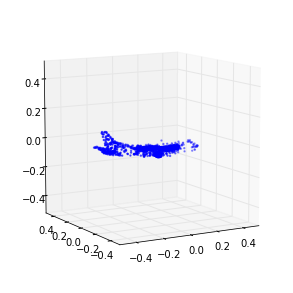

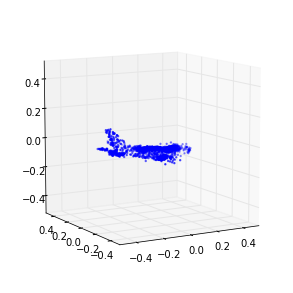

1101 (0.93014354302602653, 1.3622840984779245) 16.0851149559
1102 (0.94061991397072287, 1.3895454187603558) 16.5664219856
1103 (0.91954091717215147, 1.3477562201373718) 17.1031110287
1104 (0.93101971640306358, 1.40557839940576) 15.9343848228
1105 (0.93082107778857737, 1.3587636062327553) 16.3289670944
1106 (0.94042380943017845, 1.3727066806134056) 15.8232369423
1107 (0.96055327355861664, 1.3668345773921293) 16.1079361439
1108 (0.91637229568818035, 1.3943941926254946) 16.3382441998
1109 (0.91498277555493746, 1.3835040620144676) 15.8327469826
1110 (0.93820248281254492, 1.3650562061982996) 16.3435721397
1111 (0.95720104960834274, 1.3948443339151495) 16.3388810158
1112 (0.93279863806331864, 1.3794705622336443) 15.8909249306
1113 (0.94795007127172803, 1.4155834264615004) 15.9583249092
1114 (0.94995363670236921, 1.375706259818638) 15.9816319942
1115 (0.93464383570586929, 1.3647241951788174) 16.0490031242
1116 (0.93174076869207267, 1.3717495325733633) 16.1670539379
1117 (0.94400138451772575, 

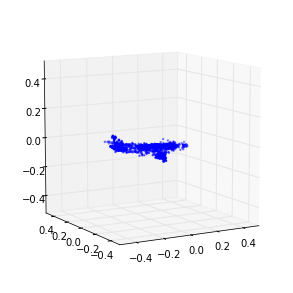

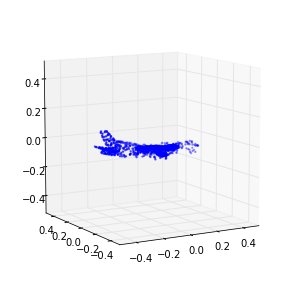

1151 (0.96506899069337282, 1.3531431170070873) 15.7699351311
1152 (0.98460440250004044, 1.3543075616745388) 15.9200761318
1153 (0.97043109027778396, 1.3398161363952301) 16.0099411011
1154 (0.95724877013879661, 1.3464820840779472) 15.8350508213
1155 (0.9345078433261198, 1.3578155242344911) 16.1423690319
1156 (0.97274930336896115, 1.3569727785447065) 16.1920678616
1157 (0.94787168064538174, 1.3376297792967629) 16.0207509995
1158 (0.90757220545235806, 1.3484570068471573) 16.6700868607
1159 (0.96327873976791611, 1.3658507483847) 15.9584748745
1160 (0.91183379467795878, 1.3541147717658211) 15.8110351562
1161 (0.91130473157938785, 1.3823324722402237) 15.9452400208
1162 (0.93177285527481757, 1.3758783936500549) 16.0908641815
1163 (0.95884575563318586, 1.3886918574571609) 15.9320950508
1164 (0.90627881621613227, 1.3618216312983458) 15.8571419716
1165 (0.92708263151785908, 1.3691039646373075) 15.9601268768
1166 (0.98134636177736168, 1.3618196678512238) 15.796931982
1167 (0.92373848487349119, 1.

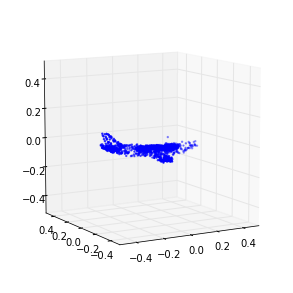

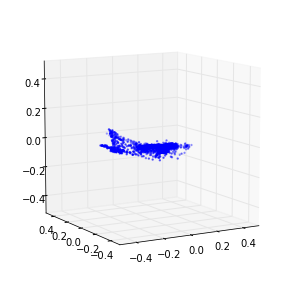

1201 (0.94827949562493496, 1.3386977954822428) 16.153375864
1202 (0.9266492908491808, 1.3692047210300671) 15.9177758694
1203 (0.93754031465334053, 1.367767548736404) 15.9566121101
1204 (0.92734758643543014, 1.3853418130208464) 16.3781950474
1205 (0.93971392337013693, 1.3587222186958088) 16.0268230438
1206 (0.92994088109801798, 1.3634884576587116) 15.733497858
1207 (0.90843326203963337, 1.3481122684829376) 15.8127601147
1208 (0.94958351815448083, 1.3493504971265793) 16.1503009796
1209 (0.94058287669630614, 1.3503290625179516) 15.8339807987
1210 (0.94215252557221585, 1.3578681577654446) 15.858923912
1211 (0.91950135984841519, 1.3254095675314175) 15.9424159527
1212 (0.96154159395133743, 1.3634410193737816) 16.0169639587
1213 (0.93204096134971171, 1.3794008107746349) 15.9002549648
1214 (0.93511573795010061, 1.3511579895720762) 16.3291358948
1215 (0.91806522011756897, 1.3659250262905569) 16.6819119453
1216 (0.91686288574162655, 1.3696813688558691) 15.9925148487
1217 (0.92256877089247979, 1.

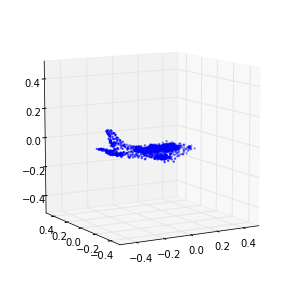

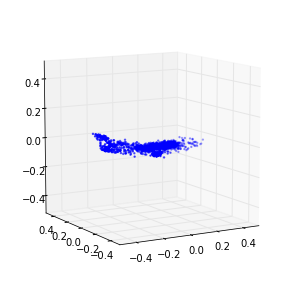

1251 (0.92697083511773282, 1.3552452124216978) 15.929610014
1252 (0.95917714255697584, 1.4032248162171419) 16.2995960712
1253 (0.95022453367710114, 1.3592996027539759) 16.2656328678
1254 (0.92047459675985221, 1.3520430221277124) 16.9183449745
1255 (0.94060879595139446, 1.3484139486270792) 16.0580809116
1256 (0.9444841987946454, 1.3555292601094526) 15.8494729996
1257 (0.93601815227200003, 1.37062768638134) 15.9771091938
1258 (0.9839236315558938, 1.3525963758721071) 15.9758529663
1259 (0.95530772472129144, 1.3534114759634523) 16.2241659164
1260 (0.93694885688669538, 1.338499021004228) 15.7989721298
1261 (0.95643993335611677, 1.3775324216660332) 15.9822840691
1262 (0.94504384258214169, 1.3510174672393238) 16.0283029079
1263 (0.97956050055868482, 1.3490539429818882) 16.299751997
1264 (0.95345358462894669, 1.3565821244436151) 16.2621109486
1265 (0.99840980943511515, 1.368301115491811) 15.7914960384
1266 (0.93669519617277031, 1.3248288350946762) 15.8399510384
1267 (0.95398937165737152, 1.380

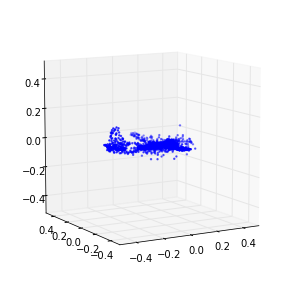

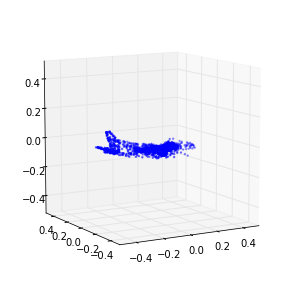

1301 (0.9308361945783391, 1.3802287219201816) 15.8813738823
1302 (0.92043400161406574, 1.4020031120847254) 15.6749849319
1303 (0.92155682514695558, 1.4046600189279108) 15.7267379761
1304 (0.91055671783054581, 1.3959520923740723) 15.6813368797
1305 (0.93320949726244984, 1.4218694331014858) 15.673484087
1306 (0.94592526029138002, 1.3709734949995489) 15.6831059456
1307 (0.95297472266589889, 1.3726208376533844) 15.695130825
1308 (0.93818043698282805, 1.3745934340883703) 15.6815030575
1309 (0.91918770267682914, 1.3834001430693794) 15.7041649818
1310 (0.88625960753244515, 1.3931544142610885) 15.7223980427
1311 (0.94461349617032442, 1.3966373880119884) 16.2847828865
1312 (0.93349458890802717, 1.4039257677162396) 15.6929428577
1313 (0.92329803635092345, 1.3649264311089235) 16.3484220505
1314 (0.91779701324070206, 1.4139336820910959) 15.6861288548
1315 (0.93651129743632144, 1.3818745323840309) 15.8467419147
1316 (0.93898313624017382, 1.3772790624814875) 16.4865880013
1317 (0.92902793077861556, 

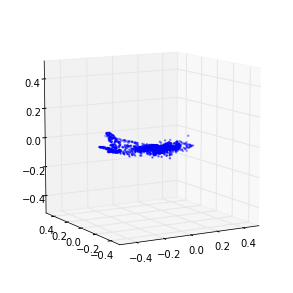

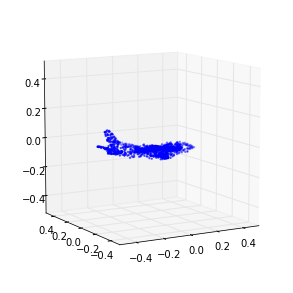

1351 (0.91633191617096177, 1.3853925571722143) 15.8159852028
1352 (0.9087918619899189, 1.4010292764972239) 15.724542141
1353 (0.94174853142570047, 1.3964703889454113) 15.6732051373
1354 (0.91819609351017895, 1.380793422460556) 15.7992150784
1355 (0.91213035232880535, 1.3800978318733328) 15.6900420189
1356 (0.90168304478420935, 1.3998908347943251) 16.3173959255
1357 (0.91318340862498559, 1.4153180849902771) 15.7104859352
1358 (0.91131216901190137, 1.3825263722854502) 15.7052140236
1359 (0.89637409939485435, 1.3877757559804356) 15.8041338921
1360 (0.91287636055665855, 1.3932822521995096) 15.7145781517
1361 (0.90626141253639669, 1.404434175175779) 15.6937170029
1362 (0.9246286548235837, 1.3829833698623322) 15.685090065
1363 (0.89485455698826732, 1.3927489159738315) 15.7305681705
1364 (0.93746404788073368, 1.4006450518089182) 15.691737175
1365 (0.92426032967427196, 1.3962460020009209) 15.6929349899
1366 (0.93582689499153815, 1.3844617473728515) 15.7201809883
1367 (0.91823366459678202, 1.42

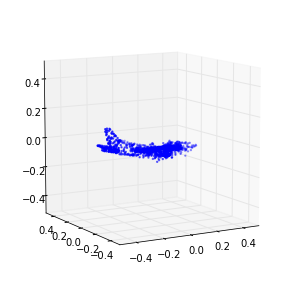

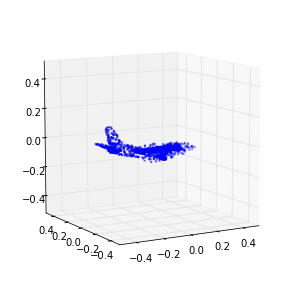

1401 (0.91561919538413772, 1.4069250690586426) 16.1325421333
1402 (0.92132639534333172, 1.3991293302353691) 15.714607954
1403 (0.90695777535438538, 1.3789492880596834) 15.8131229877
1404 (0.92082555329098426, 1.4021839087500292) 15.9111549854
1405 (0.91371038994368381, 1.3775448860491024) 15.7438590527
1406 (0.9236249441609663, 1.3906269196201773) 15.973706007
1407 (0.9498205702094471, 1.3981991813463324) 15.6847150326
1408 (0.95717117979246025, 1.3882166673155392) 15.7025702
1409 (0.91625072237323313, 1.394626564839307) 15.6542870998
1410 (0.89264969965990848, 1.3906760575140225) 15.7580590248
1411 (0.92188787460327148, 1.3902648117612391) 15.729418993
1412 (0.89909276190926046, 1.3994417234378702) 15.6743011475
1413 (0.92262965791365681, 1.3939850295291227) 15.848498106
1414 (0.90808149733964139, 1.3783432122539072) 15.6763219833
1415 (0.92730909761260538, 1.3967285848715727) 15.8600759506
1416 (0.89105938550303965, 1.3867151079808964) 15.7188489437
1417 (0.89819993166362533, 1.39571

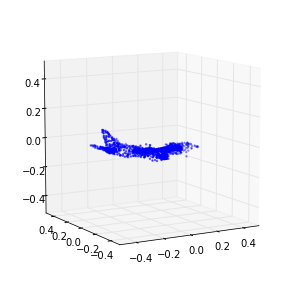

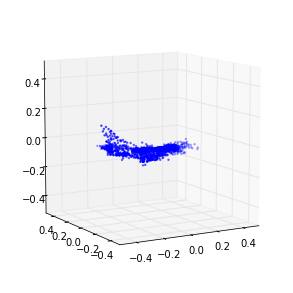

1451 (0.88577239303027877, 1.3768657437142204) 15.9135591984
1452 (0.92185836679795208, 1.3963393796892727) 15.6808791161
1453 (0.8890873123617733, 1.3883864257265539) 15.9380590916
1454 (0.89242246133439684, 1.3712218693074059) 15.6890380383
1455 (0.87901168623391324, 1.4191306356121511) 15.9247848988
1456 (0.90574239895624276, 1.3725392581785427) 15.8977658749
1457 (0.90969617489506216, 1.3852152070578407) 15.6850879192
1458 (0.9023493624785367, 1.3653070584816092) 15.9121730328
1459 (0.92059376309899721, 1.3702852892525055) 15.6800358295
1460 (0.89731796699411726, 1.3705832248224932) 15.9928450584
1461 (0.90840115179033842, 1.3933857793317121) 15.7217099667
1462 (0.89011239654877605, 1.4080157569226097) 15.9684388638
1463 (0.90468713115243349, 1.3739531145376318) 15.6545958519
1464 (0.91666458547115326, 1.3874907142975752) 15.6306200027
1465 (0.90164822427665481, 1.387159072300967) 15.9916250706
1466 (0.91404485965476312, 1.3945569610771011) 15.6703088284
1467 (0.91478828559903536, 

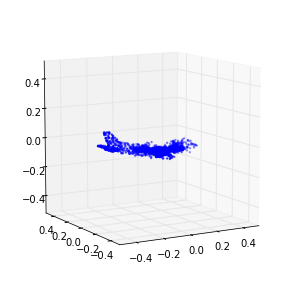

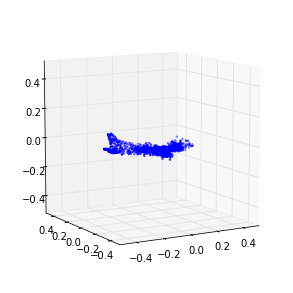

1501 (0.9049220067613265, 1.3955766944324268) 15.7800250053
1502 (0.89528086869155654, 1.4210391211159088) 15.9064331055
1503 (0.89786186463692608, 1.3956708014011383) 15.9802289009
1504 (0.91550398398848143, 1.3836550370735281) 15.6753981113
1505 (0.89661141616456652, 1.401853497414028) 15.9460048676
1506 (0.89261196729014902, 1.3944840667878879) 15.9587168694
1507 (0.89627482785898094, 1.4004115988226498) 15.7075340748
1508 (0.88872115051045142, 1.394643544274218) 15.9403569698
1509 (0.90248093797880058, 1.4065201484105165) 15.6856040955
1510 (0.89524004652219658, 1.3903788179159164) 16.0505180359
1511 (0.87909019869916583, 1.389066779438187) 15.7045049667
1512 (0.90295598349150485, 1.3969086794292225) 15.7413179874
1513 (0.9013442177982891, 1.403905368903104) 15.6827011108
1514 (0.90010297035469733, 1.3902094469350927) 15.6989378929
1515 (0.89275383160394783, 1.3850592225790024) 15.7192909718
1516 (0.88871704567881193, 1.4076012206428192) 15.9724850655
1517 (0.8994002622716567, 1.39

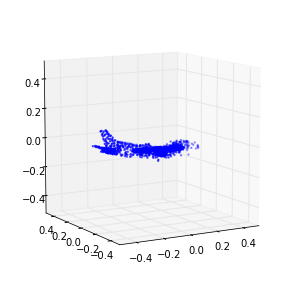

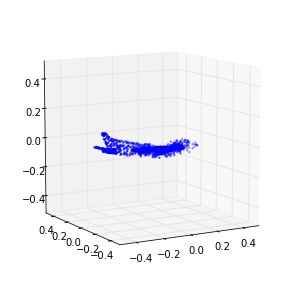

1551 (0.91697232249905081, 1.3870917190523708) 15.9251081944
1552 (0.92608354284482841, 1.386389862965135) 15.6799149513
1553 (0.89672202222487507, 1.3948287245105295) 16.0286998749
1554 (0.9333680535064024, 1.4255600817063276) 15.6923441887
1555 (0.94881363914293404, 1.3641260555561852) 15.7246360779
1556 (0.92700987966621629, 1.3700561242945053) 15.6939029694
1557 (0.92059281293083639, 1.3825321688371546) 16.9473159313
1558 (0.90182708817369794, 1.3960079261485268) 15.7078142166
1559 (0.89728159150656528, 1.3939728395027273) 16.1469550133
1560 (0.93606209404328289, 1.3902634583851869) 15.6876912117
1561 (0.90625679931219882, 1.4075238625792896) 15.6808998585
1562 (0.91272463868646059, 1.3714869706069721) 16.0047600269
1563 (0.90378056554233321, 1.400496673058061) 15.9290680885
1564 (0.88919131720767297, 1.376492102356518) 15.6953239441
1565 (0.91826586512958297, 1.3863877864444958) 15.6710600853
1566 (0.90880953389055585, 1.3984888248583849) 15.8559319973
1567 (0.87991745419362011, 1

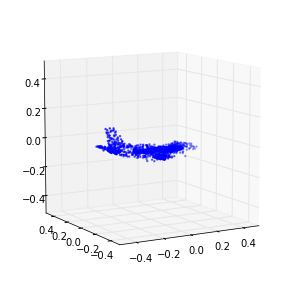

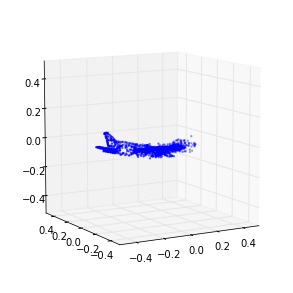

1601 (0.89610421043985033, 1.3952382233212977) 16.0476489067
1602 (0.89226559155127583, 1.4171017627505695) 15.9631540775
1603 (0.87146755614701443, 1.4195625185966492) 15.8198740482
1604 (0.85522952412857733, 1.415841800325057) 15.8545629978
1605 (0.88250252516830674, 1.4541287071564619) 15.8493521214
1606 (0.87670483834603252, 1.4103001636617325) 16.0769460201
1607 (0.85969257617697992, 1.4415266741724575) 16.0048398972
1608 (0.86215877269997321, 1.420788924483692) 15.9892699718
1609 (0.87133400229846725, 1.4152274640167462) 15.9763550758
1610 (0.87985165241886587, 1.4289188788217657) 15.889095068
1611 (0.88267604568425351, 1.4405007669154335) 15.9926152229
1612 (0.87145949111265297, 1.4143176105092554) 16.0374259949
1613 (0.89916217151810141, 1.4189765282413538) 16.1731069088
1614 (0.85604020602562847, 1.42643143324291) 15.8283100128
1615 (0.88582942065070658, 1.42162906071719) 16.1309530735
1616 (0.86337975631741914, 1.4133101973463507) 16.1657500267
1617 (0.88625211750759803, 1.40

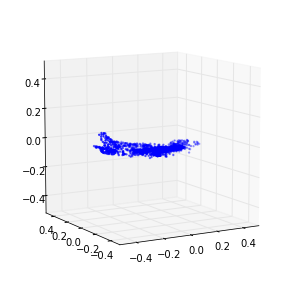

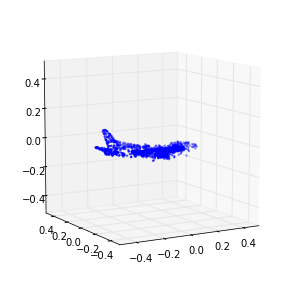

1651 (0.88135664427981653, 1.4055095314979553) 15.8001980782
1652 (0.87170717558440036, 1.426393655293128) 16.0292429924
1653 (0.86169046777136182, 1.4274127571021809) 15.8706469536
1654 (0.9248673162039589, 1.4101291982566608) 15.8023538589
1655 (0.87349244075662946, 1.4228582461090649) 15.8654839993
1656 (0.87221527888494377, 1.4172440276426428) 15.938806057
1657 (0.86968883784378281, 1.4087385964744232) 15.899064064
1658 (0.85977506900534906, 1.4170038393315147) 16.0523309708
1659 (0.8795822148813921, 1.4300839077023899) 15.8363070488
1660 (0.88608614311498757, 1.4189287353964413) 16.0595779419
1661 (0.87537787679363699, 1.421327094821369) 15.768545866
1662 (0.89542688166393958, 1.4168059045777601) 16.2622258663
1663 (0.8617021765779046, 1.4342460500843384) 15.818310976
1664 (0.86749479963498954, 1.4266697720569723) 15.962346077
1665 (0.87875671860049753, 1.4362410377053654) 15.7678670883
1666 (0.85742813787039585, 1.4240561487043606) 15.8108930588
1667 (0.85995827878222741, 1.43620

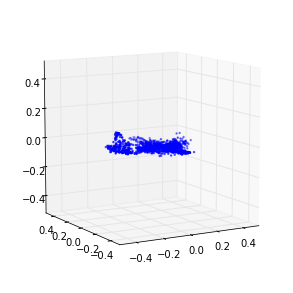

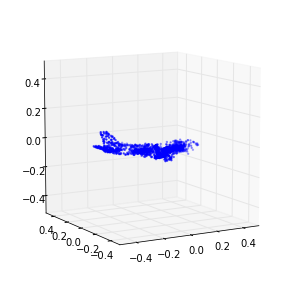

1701 (0.85511856657617236, 1.4389673795770197) 16.621243
1702 (0.8510141784653944, 1.4647777641520781) 15.9590861797
1703 (0.86331984137787543, 1.4297208926256966) 16.0974440575
1704 (0.86343544721603394, 1.4565351132084341) 16.2955009937
1705 (0.85964807079118843, 1.4417490257936365) 15.8135530949
1706 (0.85217567927697124, 1.4314159768469192) 16.6615130901
1707 (0.84115958476767816, 1.446519977906171) 16.2916059494
1708 (0.84627625346183777, 1.4506955304566551) 15.9767029285
1709 (0.86595532385741958, 1.4472615981803221) 16.1207880974
1710 (0.86613589612876662, 1.441042926381616) 15.8683550358
1711 (0.862390481373843, 1.4360761370728998) 16.33604002
1712 (0.87535874633228072, 1.4542979703230017) 16.001609087
1713 (0.87991345104049234, 1.4335481296567356) 16.3322339058
1714 (0.86547106329132528, 1.4196721280322355) 16.8115279675
1715 (0.87642931762863607, 1.4367593868690378) 15.9427740574
1716 (0.85420736933455743, 1.4314327739617403) 16.2714300156
1717 (0.84051232828813438, 1.4537810

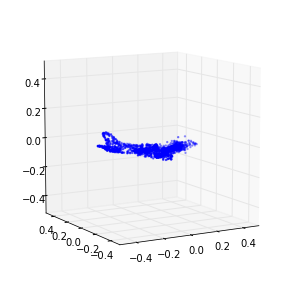

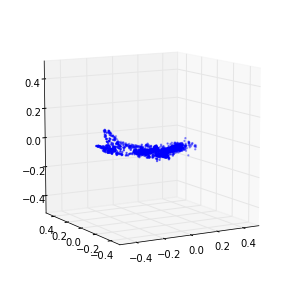

1751 (0.83332570335444278, 1.5038509956177544) 15.9298701286
1752 (0.8294422582668417, 1.4964712963384741) 15.8971760273
1753 (0.84625127999221572, 1.5185131500749027) 16.0916509628
1754 (0.81384653992512646, 1.5021066832191803) 16.6732678413
1755 (0.87596305152949161, 1.4801046488916172) 16.2588281631
1756 (0.8490268737077713, 1.4999880071948557) 15.8319690228
1757 (0.86114932070760164, 1.4973209798336029) 16.0226638317
1758 (0.84882174782893238, 1.4922074254821329) 16.5041160583
1759 (0.8560696936705533, 1.5201740291188746) 16.0930190086
1760 (0.85194171351545001, 1.4654487906133427) 15.9196770191
1761 (0.82977899120134468, 1.4800717436215456) 16.198870182
1762 (0.85743126185501328, 1.5025192025829763) 15.817013979
1763 (0.82762747389428759, 1.5150712702204199) 16.60658288
1764 (0.85810131798772249, 1.5263010061839049) 16.1183080673
1765 (0.85069223624818469, 1.5014766121611876) 15.8120450974
1766 (0.85229868573300982, 1.4792085570447586) 16.0592880249
1767 (0.84810414340566187, 1.53

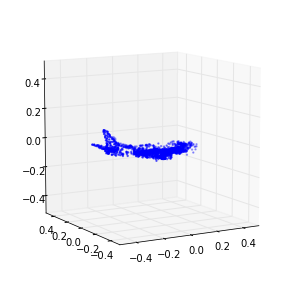

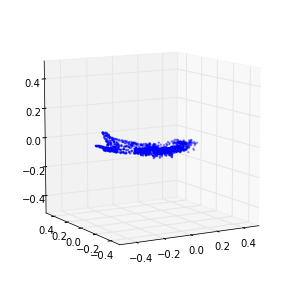

1801 (0.82065640389919281, 1.5057799684650757) 15.8323779106
1802 (0.81515958554604473, 1.5124729985699934) 15.8018009663
1803 (0.82729256503722248, 1.5190160493640339) 16.3082880974
1804 (0.8150358515627244, 1.5028414060087765) 16.2572619915
1805 (0.82089878180447751, 1.4877878234666937) 16.0583679676
1806 (0.801336391007199, 1.4864648414008759) 16.1447079182
1807 (0.83141938027213602, 1.4668279228841556) 15.8055269718
1808 (0.81129205226898193, 1.4937408829436583) 16.1897220612
1809 (0.83707196046324339, 1.4739771897301954) 15.9346280098
1810 (0.83276172683519478, 1.4968409433084375) 16.3485569954
1811 (0.82616678756826067, 1.4706093143014347) 15.9369990826
1812 (0.82351966289912948, 1.4868837121654959) 16.0105628967
1813 (0.813737063723452, 1.4850155045004452) 16.3106489182
1814 (0.85276445746421814, 1.500436947626226) 15.9144999981
1815 (0.80590260642416334, 1.49685998173321) 16.0639300346
1816 (0.83748917018665991, 1.4908719308236067) 16.6992349625
1817 (0.85451535968219527, 1.492

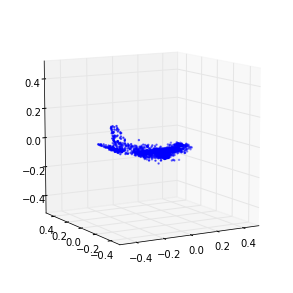

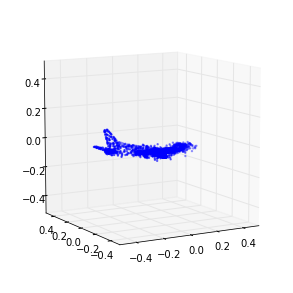

1851 (0.8114479657481698, 1.5201477855443954) 16.7326698303
1852 (0.80284140653469982, 1.5291300836731405) 15.9515109062
1853 (0.8123026174657485, 1.5140959743191214) 16.1671760082
1854 (0.82707569178412943, 1.5418229637777103) 16.0526108742
1855 (0.82214408061083621, 1.5335412007920883) 15.8932011127
1856 (0.85419578674961538, 1.5326141566038132) 16.1342189312
1857 (0.81003786009900713, 1.5269000565304476) 16.0870769024
1858 (0.81084807217121124, 1.556771555367638) 15.9129829407
1859 (0.81614067887558661, 1.5117437918396557) 16.140130043
1860 (0.83449198480914621, 1.5324445805128883) 17.1294851303
1861 (0.79686060547828674, 1.5068880004041336) 15.9400479794
1862 (0.81864731802659874, 1.5438563657157562) 15.7967419624
1863 (0.83827998445314522, 1.5305368663633572) 16.403717041
1864 (0.80946771449902477, 1.5232801507501041) 15.890570879
1865 (0.8314768111004549, 1.5145106525982128) 16.6048221588
1866 (0.83180607592358313, 1.4970929806723314) 16.1882519722
1867 (0.83273133460213156, 1.51

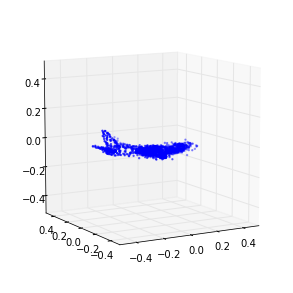

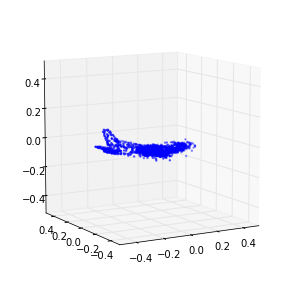

1901 (0.80770181119441986, 1.4959314632065155) 15.8563430309
1902 (0.81573033683440266, 1.5329558113042046) 16.1344630718
1903 (0.81290084649534788, 1.5078910957364475) 16.1016709805
1904 (0.78938763544839974, 1.5380075416144203) 15.9390928745
1905 (0.80534826306735763, 1.5307991311830633) 16.0017199516
1906 (0.80845407615689668, 1.5710154666620142) 15.9517669678
1907 (0.78993559935513669, 1.5596214734456118) 16.1882820129
1908 (0.78190253061406756, 1.5672472206985248) 15.9066720009
1909 (0.80679271238691663, 1.5579031407833099) 16.0885820389
1910 (0.82268182144445534, 1.5541741497376387) 16.1319448948
1911 (0.79500819655025712, 1.5255174566717709) 16.4385139942
1912 (0.8185602584305931, 1.5492115537909901) 15.910820961
1913 (0.80261978682349711, 1.5216113188687492) 15.8350760937
1914 (0.79053409222294302, 1.5481488143696505) 16.4265611172
1915 (0.8068103693863925, 1.5373290899921865) 16.1190488338
1916 (0.82255293954821196, 1.5381651135051952) 16.1176769733
1917 (0.77730549039209595, 

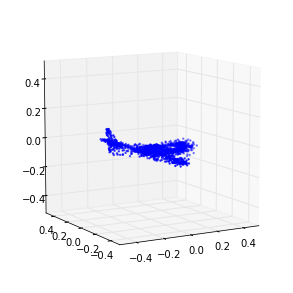

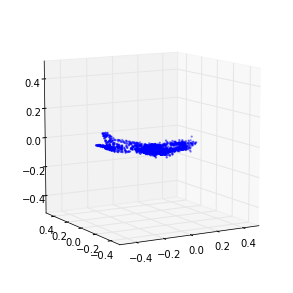

1951 (0.78429026901721954, 1.5685162842273712) 15.8216400146
1952 (0.78188687387634725, 1.5646288745543535) 16.6199128628
1953 (0.75666130027350254, 1.5867097290123211) 15.786867857
1954 (0.7600315905669156, 1.5859545451753281) 16.14559412
1955 (0.79854101731496696, 1.5736689725342918) 16.3702430725
1956 (0.76671431958675385, 1.545492353684762) 16.8315899372
1957 (0.77759652365656462, 1.572937597246731) 15.9484429359
1958 (0.77290425493436699, 1.5407238620169021) 16.3250439167
1959 (0.77225038496886977, 1.5404605208074345) 16.2847809792
1960 (0.7664649355060914, 1.5666349863304811) 15.9827170372


In [ ]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
        train_stats.append((epoch,) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')